## Import Module

In [1]:
import struct
import numpy as np
import pandas as pd
# import import_ipynb
from importnb import Notebook
with Notebook(): 
    import NN_HW3_sm as NN
    import CNN_pool_class as CNN
from tqdm import tqdm, trange, notebook
from matplotlib import pyplot as plt
np.seterr(all='raise')

{'divide': 'warn', 'over': 'warn', 'under': 'ignore', 'invalid': 'warn'}

## Read Data Function

In [2]:
def read_data(image_dir, label_dir):
    with open(image_dir, 'rb') as file:
        magic, size, rows, cols = struct.unpack(">IIII", file.read(16))
        
        buf = file.read(size * rows * cols)
        img_data = np.frombuffer(buf, dtype=np.uint8).astype(np.float64)
        img_data = img_data.reshape(size, 1, rows, cols)
        img_data = img_data / 255
        
    
    with open(label_dir, 'rb') as file:
        magic, size = struct.unpack(">II", file.read(8))
        
        buf = file.read(size)
        lab_data_tmp = np.frombuffer(buf, dtype=np.uint8).astype(np.uint16)
        lab_data_tmp = lab_data_tmp.reshape(size)
        
#     print(lab_data[0:111])
    lab_data = np.zeros((size, 10), dtype=np.uint16)
    for i in range(size):
        lab_data[i][ lab_data_tmp[i] ] = 1
    
#     print(lab_data[0:10])
    
    
    return img_data.copy(), lab_data.copy()

In [3]:
# print(np.frombuffer(b'\x02\x01\x00\x00', dtype=np.uint16))
train_data, train_label  = read_data('./MNIST/train-images-idx3-ubyte', './MNIST/train-labels-idx1-ubyte')
test_data, test_label  = read_data('./MNIST/t10k-images-idx3-ubyte', './MNIST/t10k-labels-idx1-ubyte')

## Dataset Label

In [4]:
def preprocess_input(x):
    return x

In [5]:
def construct_model(model):
    #### First Convolution + pooling
    # func, d_func, last_layer, input_size, input_num, filter_size, filter_num, stride
    model.layer_list.append( CNN.ConvLayer(NN.Sigmoid, NN.d_Sigmoid, 1, input_size=28, input_num=1, filter_size=5, filter_num=3, stride=1, is_first=True))
    # last_layer, input_size, input_num, filter_size, stride
    model.layer_list.append( CNN.AvgPooling(model.layer_list[len(model.layer_list)-1], input_size=24, input_num=3, filter_size=4, stride=2, is_first=False))   
    
    #### Second Convolution + pooling
    # func, d_func, last_layer, input_size, input_num, filter_size, filter_num, stride
    model.layer_list.append( CNN.ConvLayer(NN.ReLU, NN.d_ReLU, model.layer_list[len(model.layer_list)-1], input_size=11, input_num=3, filter_size=3, filter_num=5, stride=1, is_first=False))
    # last_layer, input_size, input_num, filter_size, stride
    model.layer_list.append( CNN.AvgPooling(model.layer_list[len(model.layer_list)-1], input_size=model.layer_list[len(model.layer_list)-1].get_output_size(), input_num=5, filter_size=3, stride=1, is_first=False))       
    
    # last_layer, input_size, input_num
    model.layer_list.append( CNN.Flattening(model.layer_list[len(model.layer_list)-1], input_size=model.layer_list[len(model.layer_list)-1].get_output_size(), input_num=5, is_first=False))
    
    #### First MLP
    # func, d_func, node_num, last_layer, is_first
    model.layer_list.append( NN.Layer_vec(NN.ReLU, NN.d_ReLU, 100, model.layer_list[len(model.layer_list)-1], False) )
    
    #### Second MLP
    # func, d_func, node_num, last_layer, is_first
    model.layer_list.append( NN.Layer_vec(NN.ReLU, NN.d_ReLU, 64, model.layer_list[len(model.layer_list)-1], False) )
    
    #### Third MLP
    # func, d_func, node_num, last_layer, is_first
    model.layer_list.append( NN.Layer_vec(NN.ReLU, NN.d_ReLU, 10, model.layer_list[len(model.layer_list)-1], False) )
    
    #### Output Layer
    model.layer_list.append( NN.Softmax_Output(model.layer_list[len(model.layer_list)-1]) )
    print(model.layer_list)
            

In [6]:
##############################################################
#                         MODEL block                        #
##############################################################

epochs = 50

lr_rate = 0.001
batch_size = 100
test_m = NN.Model(construct_model, batch_size, lr_rate)

train_loss = []
test_loss = []
train_acc = []
test_acc = []
output_node_w = [[]]
output_node_w = np.array([test_m.get_output_w()])
need_update = False

for epoch in range(epochs):
    train_err_cnt = 0
    train_error = []
    print(epoch+1, "/", epochs, "epochs")
    train_progress = notebook.tqdm(total=len(train_data), desc="Training")
    test_progress = notebook.tqdm(total=len(test_data), desc="Testing")
    for i, input_data in enumerate(train_data):
        
        if i % batch_size == 0:
            need_update = True
        train_progress.update(1)
        p_data = preprocess_input(input_data)
        test_m.cal_network(p_data)
        
        ans_conf = test_m.get_result()
        ans = np.argmax(ans_conf)
        std = np.argmax(train_label[i])
        if ans != std:
            train_err_cnt += 1
        
        # Adjust model weights
        p_loss = test_m.adjust_model(train_label[i], need_update)
        train_error.append(p_loss)
        
        need_update = False
        
    output_node_w = np.append(output_node_w, [test_m.get_output_w()], 0)
        
    train_loss.append(np.average(train_error))
    train_acc.append(1 - train_err_cnt/len(train_data) )
    print("Train loss: ", np.average(train_error), ", acc = ", (1-train_err_cnt/len(train_data)) * 100, "%")
    test_err_cnt = 0
    test_error = []
    for i, input_data in enumerate(test_data):
        test_progress.update(1)
        
        p_data = preprocess_input(input_data)
        test_m.cal_network(p_data)
        ans_conf = test_m.get_result()
        ans = np.argmax(ans_conf)
        std = np.argmax(test_label[i])
        if ans != std:
            test_err_cnt += 1
        
        p_loss = test_m.get_loss(test_label[i])
        test_error.append(p_loss)
        
        
    test_loss.append(np.average(test_error))
    test_acc.append(1 - test_err_cnt/len(test_data) )
    print("Test loss: ", np.average(test_error), ", acc = ", (1-test_err_cnt/len(test_data)) * 100, "%")
    print()
test_m.get_loss()

[<CNN_pool_class.ConvLayer object at 0x00000222478E5F98>, <CNN_pool_class.AvgPooling object at 0x00000222478F0048>, <CNN_pool_class.ConvLayer object at 0x00000222478F0080>, <CNN_pool_class.AvgPooling object at 0x00000222478F00B8>, <CNN_pool_class.Flattening object at 0x00000222478F00F0>, <NN_HW3_sm.Layer_vec object at 0x00000222478F0128>, <NN_HW3_sm.Layer_vec object at 0x00000222447FE080>, <NN_HW3_sm.Layer_vec object at 0x00000222478F0208>, <NN_HW3_sm.Softmax_Output object at 0x00000222478F0240>]
1 / 50 epochs


Train loss:  1.630513944326759 , acc =  45.123333333333335 %
Test loss:  0.656932378378717 , acc =  77.39 %

2 / 50 epochs


Train loss:  0.5716136709214703 , acc =  80.49833333333333 %
Test loss:  0.29645341052381585 , acc =  90.13 %

3 / 50 epochs


Train loss:  0.2609146253265762 , acc =  91.835 %
Test loss:  0.238349166805452 , acc =  92.0 %

4 / 50 epochs


Train loss:  0.21172143701070678 , acc =  93.23833333333333 %
Test loss:  0.21146202954267845 , acc =  92.57 %

5 / 50 epochs


Train loss:  0.18770186454585058 , acc =  94.06 %
Test loss:  0.19334025450569442 , acc =  93.39999999999999 %

6 / 50 epochs










Train loss:  0.1704490612163627 , acc =  94.51666666666667 %
Test loss:  0.1756044775512505 , acc =  94.14 %

7 / 50 epochs


Train loss:  0.15801585130812748 , acc =  94.86 %
Test loss:  0.17715807305405393 , acc =  94.13 %

8 / 50 epochs


Train loss:  0.14651283217155178 , acc =  95.29166666666666 %
Test loss:  0.18231650937768945 , acc =  94.07 %

9 / 50 epochs


Train loss:  0.1377527306039626 , acc =  95.57 %
Test loss:  0.17689266948121843 , acc =  94.19999999999999 %

10 / 50 epochs


Train loss:  0.1291690483694668 , acc =  95.87333333333333 %
Test loss:  0.18033890096678395 , acc =  94.12 %

11 / 50 epochs


Train loss:  0.12329516276797854 , acc =  96.02166666666668 %
Test loss:  0.1817387816868039 , acc =  94.17999999999999 %

12 / 50 epochs


Train loss:  0.11757551519112712 , acc =  96.27333333333333 %
Test loss:  0.18325934605688007 , acc =  94.17999999999999 %

13 / 50 epochs


Train loss:  0.11332578427894244 , acc =  96.345 %
Test loss:  0.16145594156182427 , acc =  94.72 %

14 / 50 epochs


Train loss:  0.10878834491742652 , acc =  96.47 %
Test loss:  0.16393634358845496 , acc =  94.93 %

15 / 50 epochs


Train loss:  0.10529464470782449 , acc =  96.61166666666666 %
Test loss:  0.16839997383369942 , acc =  94.78 %

16 / 50 epochs


Train loss:  0.10218745938134689 , acc =  96.765 %
Test loss:  0.16969564626588055 , acc =  94.8 %

17 / 50 epochs


Train loss:  0.09969929822913715 , acc =  96.84833333333333 %
Test loss:  0.17029005846735198 , acc =  94.93 %

18 / 50 epochs


Train loss:  0.09758905865784226 , acc =  96.87333333333333 %
Test loss:  0.17859762054587955 , acc =  94.82000000000001 %

19 / 50 epochs


Train loss:  0.0940130984567756 , acc =  96.95 %
Test loss:  0.16345418710644763 , acc =  95.05 %

20 / 50 epochs


Train loss:  0.09294010014477379 , acc =  97.03333333333333 %
Test loss:  0.16741955805053133 , acc =  94.96 %

21 / 50 epochs


Train loss:  0.0895791302942657 , acc =  97.02166666666666 %
Test loss:  0.166552318981238 , acc =  95.02000000000001 %

22 / 50 epochs


Train loss:  0.0888206256002651 , acc =  97.09666666666666 %
Test loss:  0.1622656644273434 , acc =  95.35 %

23 / 50 epochs


Train loss:  0.08810654678808458 , acc =  97.08666666666666 %
Test loss:  0.16548170053434502 , acc =  95.26 %

24 / 50 epochs


Train loss:  0.08490540877175731 , acc =  97.23666666666666 %
Test loss:  0.16943414810614452 , acc =  95.12 %

25 / 50 epochs


Train loss:  0.08418820602354282 , acc =  97.21499999999999 %
Test loss:  0.14461462044298187 , acc =  95.99 %

26 / 50 epochs


Train loss:  0.08246140862230013 , acc =  97.28833333333333 %
Test loss:  0.1647760288604835 , acc =  95.3 %

27 / 50 epochs


Train loss:  0.08106875752937436 , acc =  97.28833333333333 %
Test loss:  0.15736758451445143 , acc =  95.61 %

28 / 50 epochs


Train loss:  0.07852178404338972 , acc =  97.47333333333333 %
Test loss:  0.16736614240716163 , acc =  95.41 %

29 / 50 epochs


Train loss:  0.07794816211323977 , acc =  97.54333333333334 %
Test loss:  0.16071805203588374 , acc =  95.56 %

30 / 50 epochs


Train loss:  0.07589364167205676 , acc =  97.495 %
Test loss:  0.14645381743987063 , acc =  96.08 %

31 / 50 epochs


KeyboardInterrupt: 

Text(0, 0.5, 'value')

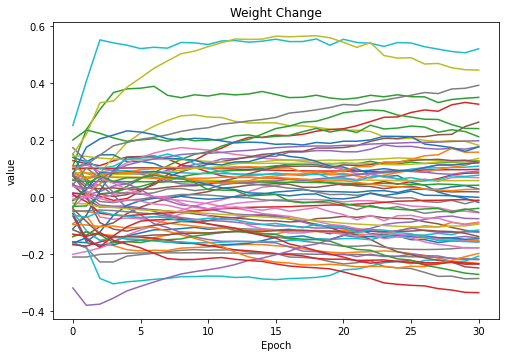

In [7]:
# write your code here
# print(output_node_w)
x= np.arange(0,len(output_node_w))
fig = plt.figure(figsize=(8,12))
fig.subplots_adjust(hspace=0.2, wspace=0.2)
plt.subplot(2,1,1)
plt.plot(x, output_node_w[:,:,0])
plt.title('Weight Change')
plt.xlabel("Epoch") 
plt.ylabel("value") 


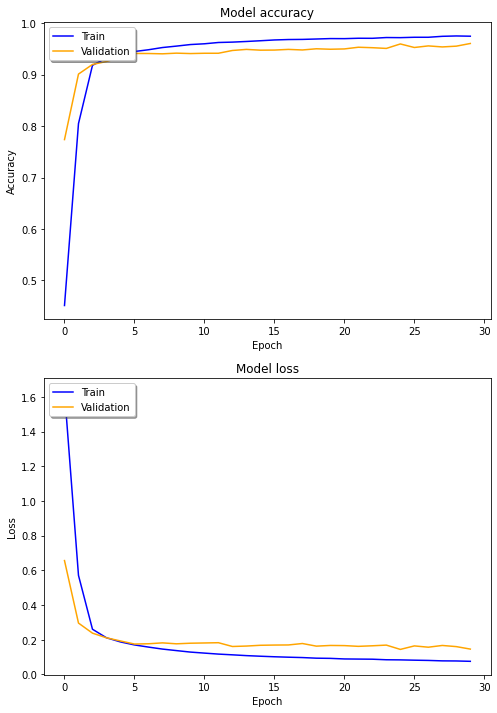

In [8]:
# write your code here
x= np.arange(0,len(train_acc))
fig = plt.figure(figsize=(8,12))
fig.subplots_adjust(hspace=0.2, wspace=0.2)
plt.subplot(2,1,1)
plt.plot(x, train_acc, color='Blue', label='Train')
plt.plot(x, test_acc, color='Orange', label='Validation')
plt.title('Model accuracy')
plt.xlabel("Epoch") 
plt.ylabel("Accuracy") 

plt.legend(loc='upper left', shadow=True) 

plt.subplot(2,1,2)
plt.plot(x, train_loss, color='Blue', label='Train')
plt.plot(x, test_loss, color='Orange', label='Validation')
plt.title('Model loss')
plt.xlabel("Epoch") 
plt.ylabel("Loss") 

plt.legend(loc='upper left', shadow=True) 